In this post, I look at a problem that has become more and more common over the last years in academia, that is, the bulk of papers that, either for misconduct, negligence, or simply for accidental human error, present inaccurate results and are ultimately retracted.
I first thought about this problem when I was approached by a journalist that wanted to dig into the issue of academic misconduct. She was curious on whether or not there were some patterns that could be identified by looking at the retractions records, although there was not a single specific question that needed to be answered. So I looked into the data, because, well, because this is what I do.

## Approach

Having no specific question on the agenda, I took the following approach for this analysis:
 - Parsing of the datasets
 - Manipulation of the dataset
 - Exploratory analysis with simple stastics and graphs
 - Additional data wrangling and refinement
 - Deeper look into the data and creation of additional graphs
 - Extraction of insighs and identification of other relevant questions for future analysis

## Datasets

Some initial research told me that there is no ultimate dataset that tracks all retracted paper, apparently. However, the Thomson Reuters Web of Science (WoS) database has a way of marking errata (that is, corrections to the original published article) and retractions. The subsample of actually retracted papers can be retrieved from the whole database by filtering for articles that include the term “retraction” in their title.
Unfortunately, this has to be done manually, exporting them to bibtex 500 records at a time.
Fortunately, there are not that many - less than 5000 overall - so the manual labor is not too taxing.

### Dataset parsing

I downloaded the dataset in bibtex format, so I needed a bibtex parser to extract the relevant information and start working on it. I here use the BibTexParser python library, with some additional customization.

In [1]:
#*******************************
# Importing packages
#*******************************
import os
import sys
import ast
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import bibtexparser
from bibtexparser.bparser import BibTexParser
from bibtexparser.customization import *
#*******************************
%matplotlib inline

In [2]:
def customizations(record):
    """
    Input record: a record
    Output: customized record
    """
    record = type(record)
    record = author(record)
    record = editor(record)
    record = journal(record)
    record = keyword(record)
    record = link(record)
    record = page_double_hyphen(record)
    record = doi(record)
    return record
#end

A few functions to parse the files (obviously, I first looked into what the parser would spit back, in order to understand what I had to work with, but I am saving that analysis to the reader) and build a nice dictionary from which to produce a Pandas DataFrame.

In [3]:
def get_retraction_list():
    n_files = 9
    base_filename = 'retraction_records_' #the name I gave to my downloaded files
    retraction_ls = list()

    parser = BibTexParser()
    parser.customization = customizations

    for ifile in range(1, n_files+1):
        filename = base_filename + str(ifile).zfill(2) + '.bib'
        with open(filename) as rec_file:
            recs_str = rec_file.read()
        #end
        retraction_ls.extend(bibtexparser.loads(recs_str, parser=parser).entries)
    #end         
    return retraction_ls
#end

def build_retraction_dc(retraction_ls):
    full_key_ls = list()
    for rec in retraction_ls:
        full_key_ls.extend(rec.keys())
    #end
    full_key_ls = list(set(full_key_ls))

    rec_dc = dict()
    for key in full_key_ls:
        rec_dc[key] = list()
    #end

    for retraction_dc in retraction_ls:
        for key in rec_dc.keys():
            if key in retraction_dc.keys():
                rec_dc[key].append(retraction_dc[key])
            else:
                rec_dc[key].extend([None])
            #end
        #end
    #end
    return rec_dc
#end

### Building the DataFrames

In [4]:
retraction_ls = get_retraction_list()
rec_dc = build_retraction_dc(retraction_ls)
retractions_df = pd.DataFrame(data=rec_dc)

/usr/local/lib/python2.7/dist-packages/bibtexparser/bparser.py:106: UnicodeWarning: Unicode equal comparison failed to convert both arguments to Unicode - interpreting them as being unequal
  if bibtex_str[:3] == byte:


Ok, let us see what it looks like.

In [5]:
retractions_df.head(1)

,ENTRYTYPE,ID,abstract,address,affiliation,article-number,author,author-email,booktitle,doc-delivery-number,...,series,times-cited,title,type,unique-id,usage-count-(last-180-days),usage-count-since-2013,volume,web-of-science-categories,year
0,article,ISI:000385601300067,None,"THE BOULEVARD, LANGFORD LANE, KIDLINGTON, OXFO...","Ashokkumar, S (Reprint Author), Annamalai Univ...",None,"[Ashokkumar, S., Ravi, S., Kathiravan, V., Vel...",None,None,DZ1MA,...,None,0,Synthesis of silver nanoparticles using A. ind...,correction,ISI:000385601300067,3,3,171,Spectroscopy,2017


In [6]:
retractions_df.keys()

Index([                  u'ENTRYTYPE',                          u'ID',
                          u'abstract',                     u'address',
                       u'affiliation',              u'article-number',
                            u'author',                u'author-email',
                         u'booktitle',         u'doc-delivery-number',
                               u'doi',                      u'editor',
                             u'eissn',     u'funding-acknowledgement',
                      u'funding-text',                        u'isbn',
                              u'issn',                     u'journal',
                       u'journal-iso',                     u'keyword',
                     u'keywords-plus',                    u'language',
                              u'link',                       u'month',
                              u'note',                      u'number',
        u'number-of-cited-references',               u'orcid-numbers',
      

In [12]:
retractions_df.iloc[1]['affiliation']

u'Ashokkumar, S (Reprint Author), Annamalai Univ, Dept Phys, Annamalainagar 608002, Tamil Nadu, India.\nAshokkumar, S.; Kathiravan, V., Annamalai Univ, Dept Phys, Annamalainagar 608002, Tamil Nadu, India.\nRavi, S.; Velmurugan, S., Annamalai Univ, Dept Engn Phys, Annamalainagar 608002, Tamil Nadu, India.'

In [11]:
retractions_df['type'][retractions_df['type']!='correction']

1188    correction; retracted publication
3213             correction; book chapter
3930    correction; retracted publication
4294                 correction, addition
4295                 correction, addition
4296                 correction, addition
4297                 correction, addition
4298                 correction, addition
4299                 correction, addition
4300                 correction, addition
4301                 correction, addition
4302                 correction, addition
4303                 correction, addition
4304                 correction, addition
4305                 correction, addition
4306                 correction, addition
4307                 correction, addition
4308                 correction, addition
4309                 correction, addition
4310                 correction, addition
4311                 correction, addition
4312                 correction, addition
4313                 correction, addition
4315                 correction, a

Still too much information. Let us try to extract only the fields that are relevant to us and reformat them to make our life easier.
A few classes may help us do that.

In [6]:
class AuthorsExtractor():
    '''
    '''
    
    def __init__(self):
        pass
    #end
    
    def get_first_author(self, author_ls):
        if isinstance(author_ls, list):
            return author_ls[0]
        else:
            return None
        #end
    #end
    
    def get_last_author(self, author_ls):
        if isinstance(author_ls, list):
            if len(author_ls)>1:
                return author_ls[-1]
            else:
                return None
            #end
        else:
            return None
        #end
    #end
    
    def get_second_author(self, author_ls):
        if isinstance(author_ls, list):
            if len(author_ls)>2:
                return author_ls[1]
            else:
                return None
            #end
        else:
            return None
        #end
    #end

    def get_middle_authors(self, author_ls):
        if isinstance(author_ls, list):
            if len(author_ls)>2:
                return author_ls[1:-1]
            else:
                return None
            #end
        else:
            return None
        #end
    #end
    
#end

class TitleExtractor():
    '''
    '''
    
    def __init__(self):
        pass
    #end
    
    def get_title(self, title):
        if title[:14]=='Retraction of ':
            title = title.replace('Retraction of ', '').replace('\n', ' ')
        elif title[:11]=='Retraction:':
            title = title.replace('Retraction: ', '').replace('\n', ' ')            
        else:
            title = title.replace('retraction', 'Retraction')
            title = title.split('Retraction ')[0].strip('()').replace('\n', ' ')
        return title
    #end
    
    def get_year_published(self, title):
        title = title.replace(' Statement of Retraction', '')
        try:
            year = int(title.replace(' )', ')').strip('()')[-4:])
        except:
            year = -9999
        #end
        return year
    #end
    
#end

Let us build a summary DataFrame now.

In [7]:
def build_summary_df(df):
    '''
    '''
    to_copy_ls = ['ID', 'author', 'journal-iso', 'title', 'publisher', \
                  'times-cited', 'number-of-cited-references', 'usage-count-since-2013', \
                  'usage-count-(last-180-days)', 'web-of-science-categories']
    s_df = df[to_copy_ls].copy(deep=True)
    ae = AuthorsExtractor()
    s_df['first_author'] = s_df['author'].apply(lambda x: ae.get_first_author(x))
    s_df['last_author'] = s_df['author'].apply(lambda x: ae.get_last_author(x))
    s_df['second_author'] = s_df['author'].apply(lambda x: ae.get_second_author(x))
    s_df['middle_authors'] = s_df['author'].apply(lambda x: ae.get_middle_authors(x))
    s_df['month_retracted'] = df['month'].apply(lambda x: str(x)[0:4])
    s_df['year_retracted'] = df['year']
    s_df['title'] = df['title'].apply(lambda s: TitleExtractor().get_title(s))
    s_df['year_published'] = df['title'].apply(lambda s: TitleExtractor().get_year_published(s))
    s_df.drop('author', axis=1, inplace=True)
    s_df['retraction_count'] = 1
    int_ls = ['year_published', 'year_retracted', 'times-cited', 'number-of-cited-references', \
              'usage-count-since-2013', 'usage-count-(last-180-days)', 'retraction_count']
    str_ls =  [field for field in s_df.columns if field not in int_ls]
    s_df[int_ls] = s_df[int_ls].astype(int)
    s_df[str_ls] = s_df[str_ls].astype(str)
    return s_df
#end

In [8]:
summary_df = build_summary_df(retractions_df)

In [9]:
summary_df.head(1)

,ID,journal-iso,title,publisher,times-cited,number-of-cited-references,usage-count-since-2013,usage-count-(last-180-days),web-of-science-categories,first_author,last_author,second_author,middle_authors,month_retracted,year_retracted,year_published,retraction_count
0,ISI:000385601300067,Spectroc. Acta Pt. A-Molec. Biomolec. Spectr.,Synthesis of silver nanoparticles using A. ind...,PERGAMON-ELSEVIER SCIENCE LTD,0,1,3,3,Spectroscopy,"Ashokkumar, S.","Velmurugan, S.","Ravi, S.","[u'Ravi, S.', u'Kathiravan, V.']",JAN,2017,2014,1


Much better!
Ok, now we can start digging into the data and get a feeling of what may be going on.

## Analysis

In this section, I am going to explore the dataset, identify some patterns, then narrow the focus to answer some specific questions.

### Some preliminary analyses

Let us start with some simple aggregate statistics.

In [10]:
summary_df.groupby(['first_author']).agg({'retraction_count': 'count'}).sort_values(by='retraction_count', 
                                                                                    ascending=False).head(4)

,retraction_count
first_author,
"{[}Anonymous],",154
"Fujii, Y.",46
"Fujii, Yoshitaka",36
"Schon, JH",32


In [11]:
summary_df.groupby(['second_author']).agg({'retraction_count': 'count'}).sort_values(by='retraction_count', 
                                                                                     ascending=False).head(4)

,retraction_count
second_author,
None,1504
"Kloc, C",19
"Saitoh, Y.",14
"Uemura, A.",7


In [12]:
summary_df.groupby(['last_author']).agg({'retraction_count': 'count'}).sort_values(by='retraction_count', 
                                                                                   ascending=False).head(4)

,retraction_count
last_author,
None,871
"Toyooka, H.",28
"Batlogg, B",21
"Kato, Shigeaki",16


In [13]:
journal_ls = ['Nature', 'Science', 'Cell']
summary_df[summary_df['journal-iso'].isin(journal_ls)].groupby(['journal-iso', 
                                                                'year_published']).agg({'retraction_count': 
                                                                                           'count'}).head(4)

retraction_count
journal-iso year_published                  
Cell        2000                           2
            2002                           2
            2003                           3
            2004                           1

In [14]:
summary_df.groupby(['year_published']).agg({'retraction_count': 'count'}).sort_values(by='retraction_count', 
                                                                                      ascending=False).head(6)

,retraction_count
year_published,
2012,384
2010,373
2014,346
2009,344
2013,331
2008,317


In [15]:
summary_df.groupby(['year_retracted']).agg({'retraction_count': 'count'}).sort_values(by='retraction_count', 
                                                                                      ascending=False).head(6)

,retraction_count
year_retracted,
2015,613
2013,516
2016,511
2014,446
2012,413
2011,395


Let us now see what are the typical numbers of authors in the retracted papers.

In [16]:
def n_authors_dist_df(ret_df):
    '''
    '''
    n_auth_dc = dict()
    for iloc in range(len(ret_df)):
        n_auth = 1
        if ret_df['last_author'].iloc[iloc]!='None':
            n_auth = n_auth + 1
        #end
        if ret_df['middle_authors'].iloc[iloc]!='None':
            n_auth = n_auth + len(ast.literal_eval(ret_df['middle_authors'].iloc[iloc]))
        #end
        if ret_df['first_author'].iloc[iloc]=='{[}Anonymous], ':
            n_auth = 0
        #end
        if str(n_auth) in n_auth_dc.keys():
            n_auth_dc[str(n_auth)] = n_auth_dc[str(n_auth)] + 1
        else:
            n_auth_dc[str(n_auth)] = 1
        #end
    #end
    n_auth_dist_df = pd.DataFrame(data={'n_authors': n_auth_dc.keys(), 'n_retractions': n_auth_dc.values()})
    n_auth_dist_df['n_authors'] = n_auth_dist_df['n_authors'].astype(int)
    n_auth_dist_df['n_rel_retractions'] = 1.0*n_auth_dist_df['n_retractions']/n_auth_dist_df['n_retractions'].sum()
    return n_auth_dist_df.sort_values(by='n_authors').reset_index(drop=True)
#end

In [17]:
n_auth_dist_df = n_authors_dist_df(summary_df)

In [18]:
n_auth_dist_df.sort_values(by='n_authors').head(8)

,n_authors,n_retractions,n_rel_retractions
0,0,154,0.035273
1,1,717,0.164224
2,2,633,0.144984
3,3,657,0.150481
4,4,581,0.133074
5,5,425,0.097343
6,6,359,0.082226
7,7,250,0.057261


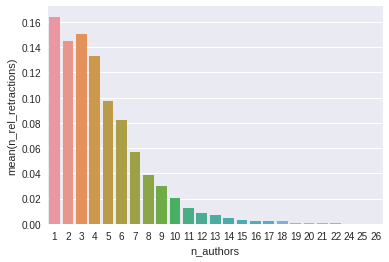

In [19]:
sns.barplot(x="n_authors", y="n_rel_retractions", data=n_auth_dist_df[n_auth_dist_df['n_authors']!=0]);

Ok, we can build much more tables and graphs, but we are starting to get the general idea. 

- It looks like some people have a really large number of retracted papers. I have spent a long time in academia and I have a good number of published papers myself, but some people have retracted more papers than I have ever published.
- Retractions appear to be increasing with time, but that may not be significant per se, as we would need to compare the fact with the total number of publications, which is also increasing overtime.
- There are too few retractions per journal per year to make an accurate granular analysis of which journals are more affected by the phenomenon.
- The dataset needs a little bit extra polishing (for example, some papers have "anonymous" authors).

There is really a large area to explore, but at this point we will need to pick a focus if we want to avoid getting lost in a myriad of graphs and tables.

### Analysis of the ancillary authors


As soon as I started looking at this dataset, I was curious about the distribution of the set of "middle authors", that is, all those authors that are in the middle of the pack, which are not usually credited with the work or its supervision, but offer some sort of contribution to it. So let us see how their distribution looks like. 

In [20]:
def build_middle_authors_df(ret_df):
    '''
    '''
    auth_dc = dict()
    for iloc in range(len(ret_df)):
        if ret_df['middle_authors'].iloc[iloc]=='None':
            auth_ls = ['Nemo']
        else:
            auth_ls = ast.literal_eval(ret_df['middle_authors'].iloc[iloc])
        #end
        for auth in auth_ls:
            if auth in auth_dc.keys():
                auth_dc[auth] = auth_dc[auth] + 1
            else:
                auth_dc[auth] = 1
            #end
        #end
    #end
    middle_authors_dc = {'middle_author': auth_dc.keys(), 'retraction_count': auth_dc.values()}
    middle_authors_df = pd.DataFrame(data=middle_authors_dc)
    return middle_authors_df.sort_values(by='retraction_count', ascending=False).reset_index(drop=True)
#end

middle_authors_df = build_middle_authors_df(summary_df)

In [21]:
middle_authors_df.head(4)

,middle_author,retraction_count
0,Nemo,1504
1,"Kloc, C",21
2,"Tanaka, H.",20
3,"Saitoh, Y.",14


As expected, the most common middle author is "Nemo", that is, lots of retracted papers have fewer than three authors. However, a few names do appear to be in several retractions, and they are NOT among those people that have the most retractions are first or last author! We will need to explore this more.

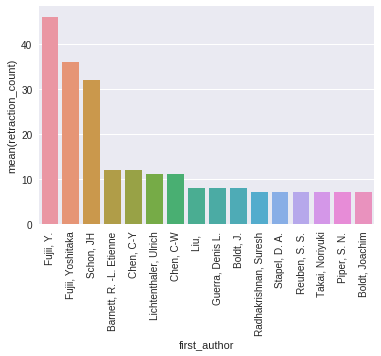

In [22]:
first_auth_df = summary_df.groupby(['first_author']).agg({'times-cited': sum, 
                                                          'usage-count-since-2013': sum, 
                                                          'retraction_count': 'count'}
                                                         ).sort_values(by='retraction_count', 
                                                                      ascending=False).reset_index()
first_auth_df = first_auth_df[first_auth_df['first_author']!='{[}Anonymous], ']
sns.barplot(x='first_author', y="retraction_count", data=first_auth_df.head(16));
plt.xticks(rotation=90);

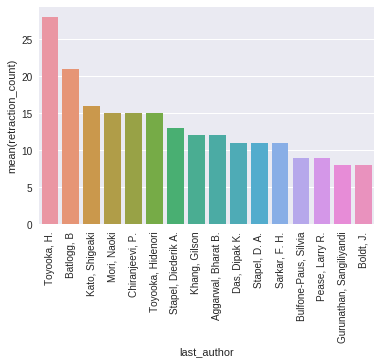

In [23]:
last_auth_df = summary_df.groupby(['last_author']).agg({'times-cited': sum, 
                                                        'usage-count-since-2013': sum, 
                                                        'retraction_count': 'count'}
                                                       ).sort_values(by='retraction_count', 
                                                                     ascending=False).reset_index()
last_auth_df = last_auth_df[last_auth_df['last_author']!='None']
sns.barplot(x='last_author', y='retraction_count', data=last_auth_df.head(16));
plt.xticks(rotation=90);

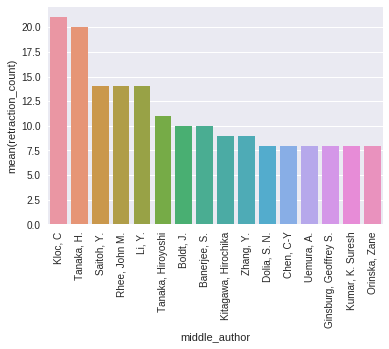

In [24]:
sns.barplot(x="middle_author", y="retraction_count", 
            data=middle_authors_df[middle_authors_df['middle_author']!='Nemo'].head(16));
plt.xticks(rotation=90);

Ok, this is interesting.
- First, there appears to be almost no overlap between the populations of "first authors", "last authors" and "middle authors", at least not for the most notable contributors to the retraction database. In other words, the people that are the "workers" of the retracted paper, usually the first authors, are not present much as "supervisors", typicall last authors, and vice versa. Additionally, there is a big group of "contributors", which do not overlap with the previous two categories, but that rack up a good deal of retracted papers. I wonder why that is!
- Second, I was not very lungimirant when I extracted the data and now I am left with fields populated by names (first and last author) and fields populated by lists (middle authors). I will need to unpack the dataset and build an author-centric DataFrame.
- Third, well, this is another bit of a problem. I am afraid that the original database was not consistent in recording the names of the authors. I have very good reason (well, because I explored the records more as soon as I noticed this) to believe that Fujii Yoshitaka and Fujii Y. can be actually the same person. A little exploration suggests that this is not an isolated case. Unfortunately, this will need to be fixed manually...

I will spare the details and all the boilerplate (it can be found in the appendix). Here is the final DatFrame. 

In [34]:
adj_author_summary_df.head(3)

,ID,author_name,first_author,last_author,middle_author,title,wos_categories
0,ISI:000315707300037,"Bose, Julie S.",1,0,0,1989 A Dihydrobenzofuran Lignan Induces Cel...,"1989 Chemistry, Medicinal Name: web-of-scie..."
1,ISI:000239914800070,"Rockley, M. G.",0,0,1,0 Theoretical investigation of the dissocia...,"0 Chemistry, Physical; Physics, Atomic, Mol..."
2,ISI:000180655500059,"Onoda, N",0,0,1,0 A novel bone marrow stroma-derived growth...,0 Immunology 1 Immunology 2 Immunolog...


With a little extra effort, we can polish things a bit and summarize everyhing for later analysis.

In [35]:
auth_df = adj_author_summary_df.groupby(['author_name']).agg({'first_author': sum, 
                                                              'last_author': sum, 
                                                              'middle_author': sum}
                                                             ).sort_values(by='first_author', 
                                                                           ascending=False).reset_index()

auth_df['count'] = auth_df['first_author'] + auth_df['last_author'] + auth_df['middle_author']
auth_df = auth_df[auth_df['author_name']!='{[}Anonymous], '][auth_df['author_name']!='None']
auth_df = auth_df.sort_values(by='count', ascending=False).reset_index(drop=True)
auth_df['first_and_last_author'] = auth_df['first_author'] + auth_df['last_author']
auth_df = auth_df.sort_values(by='count', ascending=False).reset_index(drop=True)

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:8: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [36]:
auth_df.head(3)

,author_name,first_author,last_author,middle_author,count,first_and_last_author
0,"Fujii, Y.",82,3,5,90,85
1,"Toyooka, H.",0,43,10,53,43
2,"Stapel, D. A.",14,25,8,47,39


Finally!
Let us now see how this looks in histogram form. I would like to have the author names on the x-axis and their retraction counts - individually stacked as first, last and middle author contributions - on the y-axis. All sorted by total retraction count. Using seaborn + native pyplot get us there, not without a little effort.

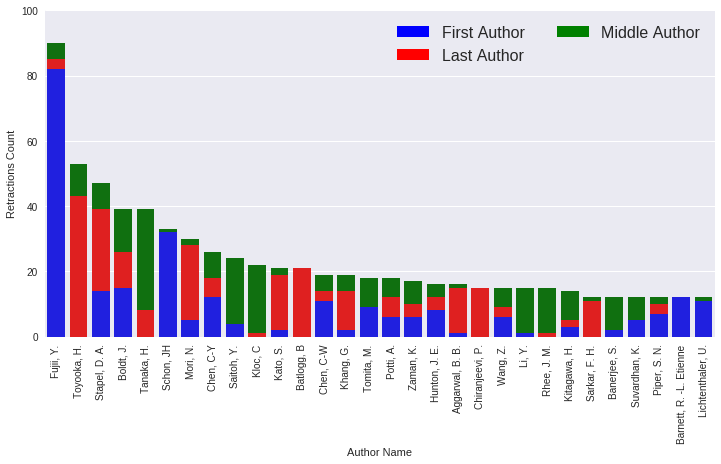

In [37]:
plt.figure(figsize=(12,6))
middle_author_bar = sns.barplot(x='author_name', y='count', data=auth_df.head(30), color='green');
last_author_bar = sns.barplot(x='author_name', y='first_and_last_author', data=auth_df.head(30), color='red');
first_author_bar = sns.barplot(x='author_name', y='first_author', data=auth_df.head(30), color='blue');
first_auth = plt.Rectangle((0,0),1,1,fc='blue', edgecolor = 'none')
last_auth = plt.Rectangle((0,0),1,1,fc='red', edgecolor = 'none')
middle_auth = plt.Rectangle((0,0),1,1,fc='green', edgecolor = 'none')
l = plt.legend([first_auth, last_auth, middle_auth], ['First Author', 'Last Author', 'Middle Author'], 
               loc=1, ncol = 2, prop={'size':16})
l.draw_frame(False)
plt.ylim([0,100])
plt.xlabel('Author Name')
plt.ylabel('Retractions Count')
plt.xticks(rotation=90);

I personally find this plot quite informative. Here is what we can say:
 - The top 5 authors have over 35 retractions (each!) under their belts
 - There are over 30 people with more than 10 retractions
 - A good number of authors appear to have a habit of being in the middle pack of the authorshio of retracted papers
 - With very few exceptions, authors contribute in a predominant way, either first, last or middle author, to their total retraction count

### Network analysis

An important part is missing to make something more than superficial out of the story so far. We have seen that a good number of authors have a lot of retracted paper in their academi CV. We have not investigated the reason for retraction in any of those cases, but it is reasonable to believe that each one of them is at least academically "negligent". Additionally, we have seen that authors are somewhat "specialized" in retracted papers, that is, some of them tend to be the first author of retracted papers, other the last, other appear everywhere else in the authorship list. This begs the questions:

 - Are there "pockets" of academic negligence?
 - Can we identify clusters of people that have contributed substantially to the academic papers' retraction records?

In order to answer these questions, I look into the co-authorship distribution and analyze the "network" of retraction using graphs. 
To this aim, I take advantage of the networks library in python and start building the graph.

#### Building nodes and edges

I follow the directions in the Networkx library documentation regarding how to build the graph. Some boilerplate functions are provided in appendix, but the main idea is to have:
 - One node for each author, with attributes describing total retraction count, and the individual counts as first, last or middle author
 - One edge for each co-authoship, with weight assigned based on how many retracted papers are shared by the given two authors

In [40]:
import networkx as nx

G = nx.Graph()

edge_weight_dbl_dc = build_edge_weight_dc(article_ID_ls, adj_author_summary_df, author_label_dc, double=True)

for auth in author_ls:
    G.add_node(auth, count=author_retraction_count_dc[auth])
    G.add_node(auth, first=author_retraction_first_dc[auth])
    G.add_node(auth, last=author_retraction_last_dc[auth])
    G.add_node(auth, middle=author_retraction_middle_dc[auth])
#end
for co_authors in edge_weight_dbl_dc:
    G.add_edge(*co_authors, weight=edge_weight_dbl_dc[co_authors])
#end


Unfortunately, the above network is extremely large, having about 15k nodes and 50k edges. We need to simplify things. To this aim, I only chose the top 8 authors by retraction count and build the network filtering out any author (and corresponding edge) that does not have at least 1 co-authored retraction with those top 8.

In [41]:
Top_n_auth_G = G.copy()

n = 8
top_n_auth_ls = list(set((auth_df['author_name'].head(n))))
top_n_auth_connection_ls = top_n_auth_ls

for auth in top_n_auth_ls:
    top_n_auth_connection_ls = top_n_auth_connection_ls + G.edge[auth].keys()
#end

top_n_auth_connection_ls = list(set(top_n_auth_connection_ls))
discard_ls = [auth for auth in author_ls if auth not in top_n_auth_connection_ls]
Top_n_auth_G.remove_nodes_from(discard_ls)


Let us plot the graph.

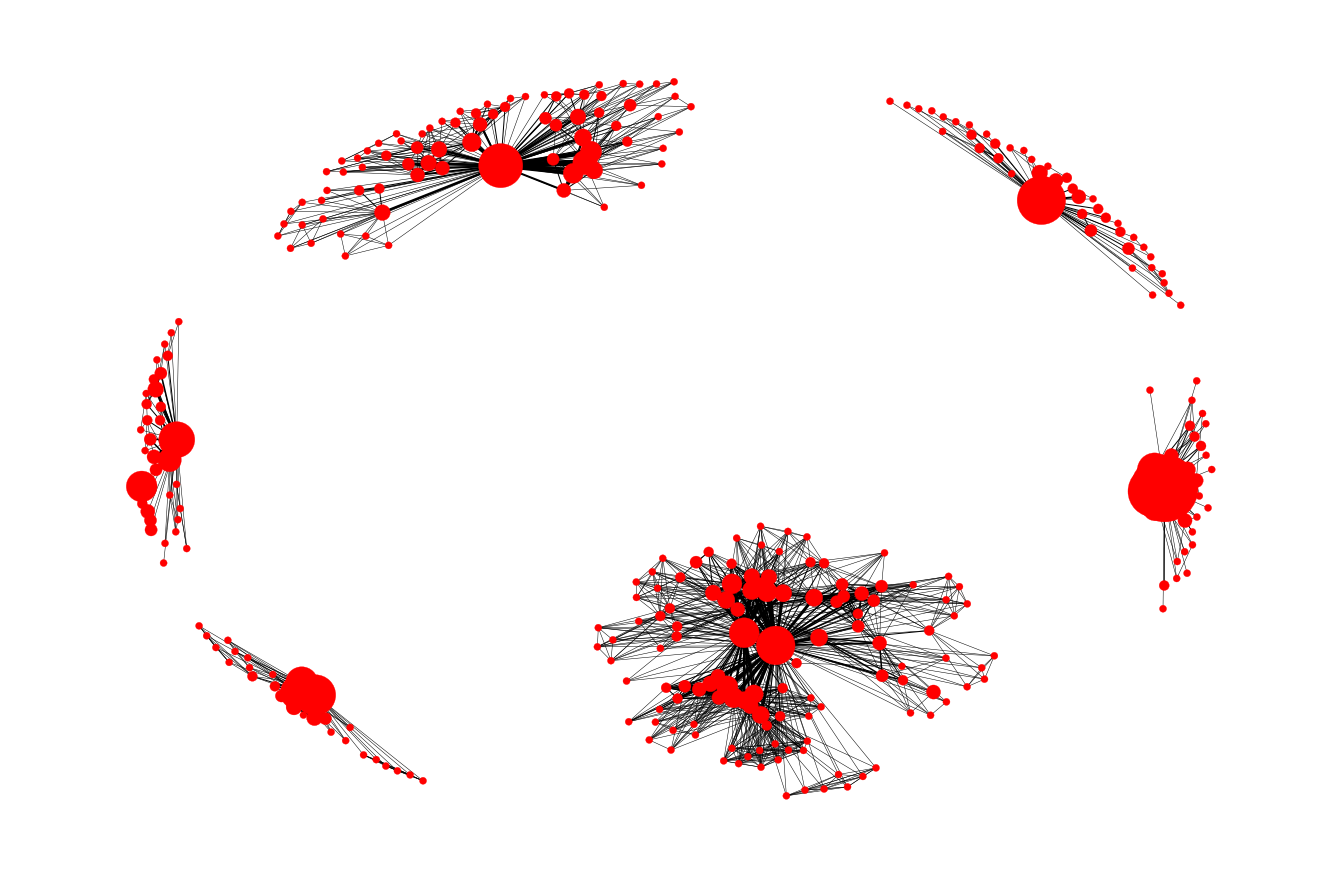

In [50]:
plt.figure(figsize=(18,12))
node_size_ls = [50*Top_n_auth_G.node[a]['count'] for a in Top_n_auth_G.nodes()]
edge_weight_ls = [0.5*Top_n_auth_G.edge[a][b]['weight'] for a, b in Top_n_auth_G.edges()]
pos = nx.spring_layout(Top_n_auth_G)
nx.draw(Top_n_auth_G, pos, node_size=node_size_ls, width=edge_weight_ls)
#nx.draw_networkx_labels(Top_n_auth_G, pos, node_size=node_size_ls, width=edge_weight_ls);
plt.savefig('./net_cluster.jpg')

There still is a lot of stuff overlapping in the graph, but a few things are quite evident:
 - The top 8 authors by retraction count make up 6 independent clusters
 - The first, second and fourth author by retraction count make up (and dominate!) one cluster, which is not that big overall
 - The cluster belongning to the 7th top author is the overall bigger one

#### Filtering out edges among minor authors

Let us see if we can polish things a bit by eliminating the edges between authors that are not in the top 8.

In [43]:
Top_n_auth_filtered_G = G.copy()

n = 8
top_n_auth_ls = list(set((auth_df['author_name'].head(n))))
top_n_auth_connection_ls = top_n_auth_ls

for auth in top_n_auth_ls:
    top_n_auth_connection_ls = top_n_auth_connection_ls + G.edge[auth].keys()
#end

top_n_auth_connection_ls = list(set(top_n_auth_connection_ls))
discard_ls = [auth for auth in author_ls if auth not in top_n_auth_connection_ls]
Top_n_auth_filtered_G.remove_nodes_from(discard_ls)

remove_edge_ls = list()
for auth in top_n_auth_connection_ls:
    for conn in Top_n_auth_filtered_G.edge[auth].keys():
        if ((auth not in top_n_auth_ls) and (conn not in top_n_auth_ls)):
            remove_edge_ls = remove_edge_ls + [(auth, conn), (conn, auth)]
        #end
    #end
#end

Top_n_auth_filtered_G.remove_edges_from(remove_edge_ls)

node_size_ls = [50*Top_n_auth_filtered_G.node[a]['count'] for a in Top_n_auth_filtered_G.nodes()]
edge_weight_ls = [0.5*Top_n_auth_filtered_G.edge[a][b]['weight'] for a, b in Top_n_auth_filtered_G.edges()]

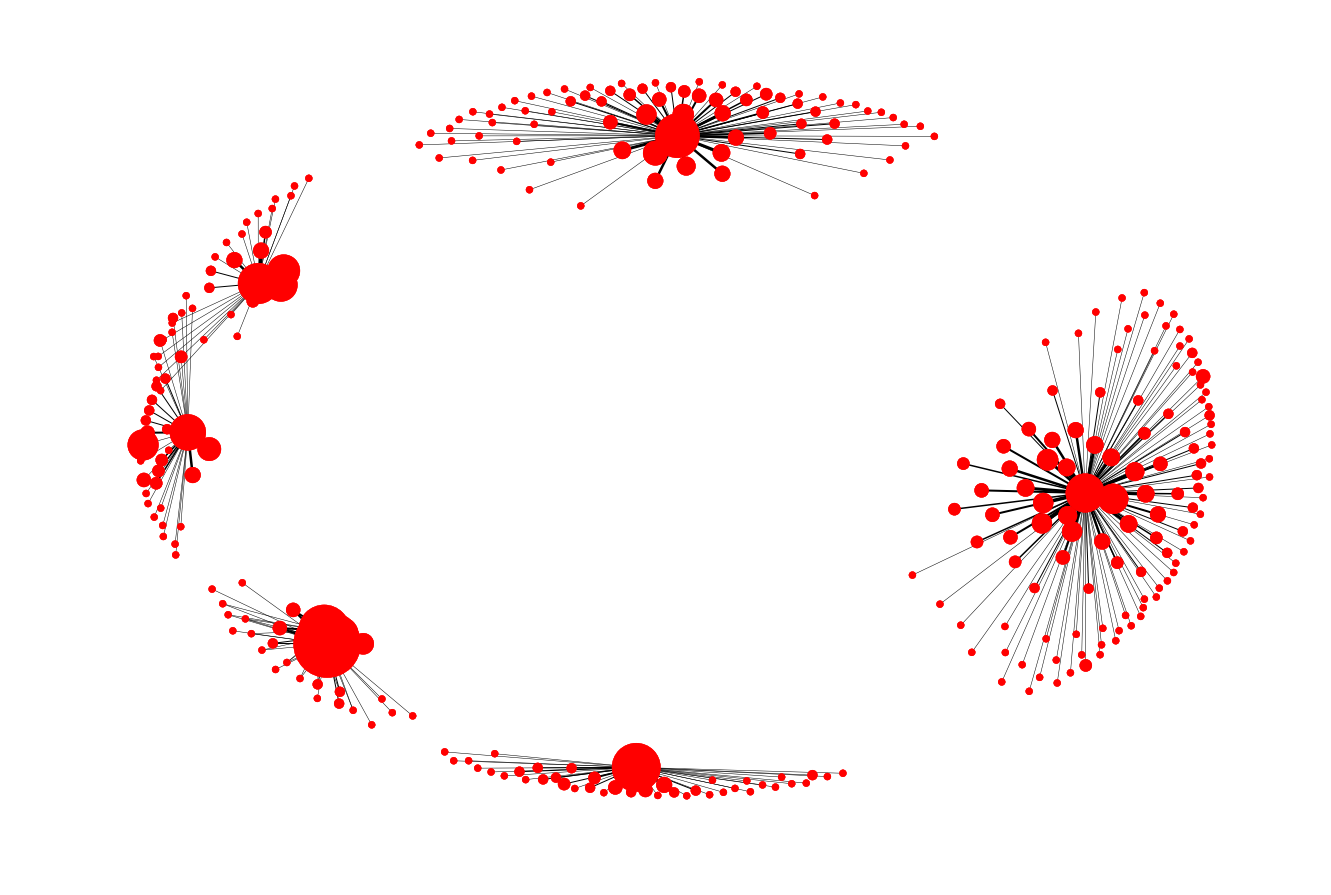

In [48]:
plt.figure(figsize=(18,12))
pos = nx.spring_layout(Top_n_auth_filtered_G)
nx.draw(Top_n_auth_filtered_G, pos, node_size=node_size_ls, width=edge_weight_ls)
nx.draw_networkx_nodes(Top_n_auth_filtered_G, pos, node_size=node_size_ls, width=edge_weight_ls, linewidth=1.0);
#nx.draw_networkx_labels(Top_n_auth_filtered_G, pos, labels=None, node_size=node_size_ls, width=edge_weight_ls);

Unfortunately, the plotting algorithm changes the position of the clusters once the network changes and we need to pay attention to which cluster we are referring to, but the overall considerations made before are reinforced by the analysis of this last plot.

#### Middle authors graph

As additional analyis, I am going to explore the clustering of middle authors only. That is, I would like to see how the top 8 authors, but middle author retraction count, are connected to the resto of the author population.

In [67]:
mddl_author_ls = list(set(adj_author_summary_df['author_name'][adj_author_summary_df['middle_author']==1]))
mddl_article_ID_ls = list(set(adj_author_summary_df['ID'][adj_author_summary_df['middle_author']==1]))
mddl_author_label_dc = dict(zip(mddl_author_ls, range(len(mddl_author_ls))))
author_retraction_count_dc = dict(zip(list(auth_df['author_name']), list(auth_df['count'])))
author_retraction_first_dc = dict(zip(list(auth_df['author_name']), list(auth_df['first_author'])))
author_retraction_last_dc = dict(zip(list(auth_df['author_name']), list(auth_df['last_author'])))
author_retraction_middle_dc = dict(zip(list(auth_df['author_name']), list(auth_df['middle_author'])))

In [68]:
mddl_adj_author_summary_df = adj_author_summary_df[adj_author_summary_df['middle_author']==1]
mddl_edge_weight_dbl_dc = build_edge_weight_dc(mddl_article_ID_ls, mddl_adj_author_summary_df, 
                                               mddl_author_label_dc, double=True)

In [69]:
G = nx.Graph()

for auth in mddl_author_ls:
    G.add_node(auth, count=author_retraction_count_dc[auth])
    G.add_node(auth, first=author_retraction_first_dc[auth])
    G.add_node(auth, last=author_retraction_last_dc[auth])
    G.add_node(auth, middle=author_retraction_middle_dc[auth])
#end
for co_authors in mddl_edge_weight_dbl_dc:
    G.add_edge(*co_authors, weight=mddl_edge_weight_dbl_dc[co_authors])
#end

In [70]:
Top_n_mddl_auth_G = G.copy()

n = 8

temp_df = auth_df.sort_values(by='middle_author', ascending=False).reset_index(drop=True)

top_n_auth_ls = list(set((temp_df['author_name'].head(n))))
top_n_auth_connection_ls = top_n_auth_ls

for auth in top_n_auth_ls:
    top_n_auth_connection_ls = top_n_auth_connection_ls + G.edge[auth].keys()
#end

top_n_auth_connection_ls = list(set(top_n_auth_connection_ls))
discard_ls = [auth for auth in author_ls if auth not in top_n_auth_connection_ls]
Top_n_mddl_auth_G.remove_nodes_from(discard_ls)

node_size_ls = [50*Top_n_mddl_auth_G.node[a]['count'] for a in Top_n_mddl_auth_G.nodes()]
edge_weight_ls = [0.5*Top_n_mddl_auth_G.edge[a][b]['weight'] for a, b in Top_n_mddl_auth_G.edges()]

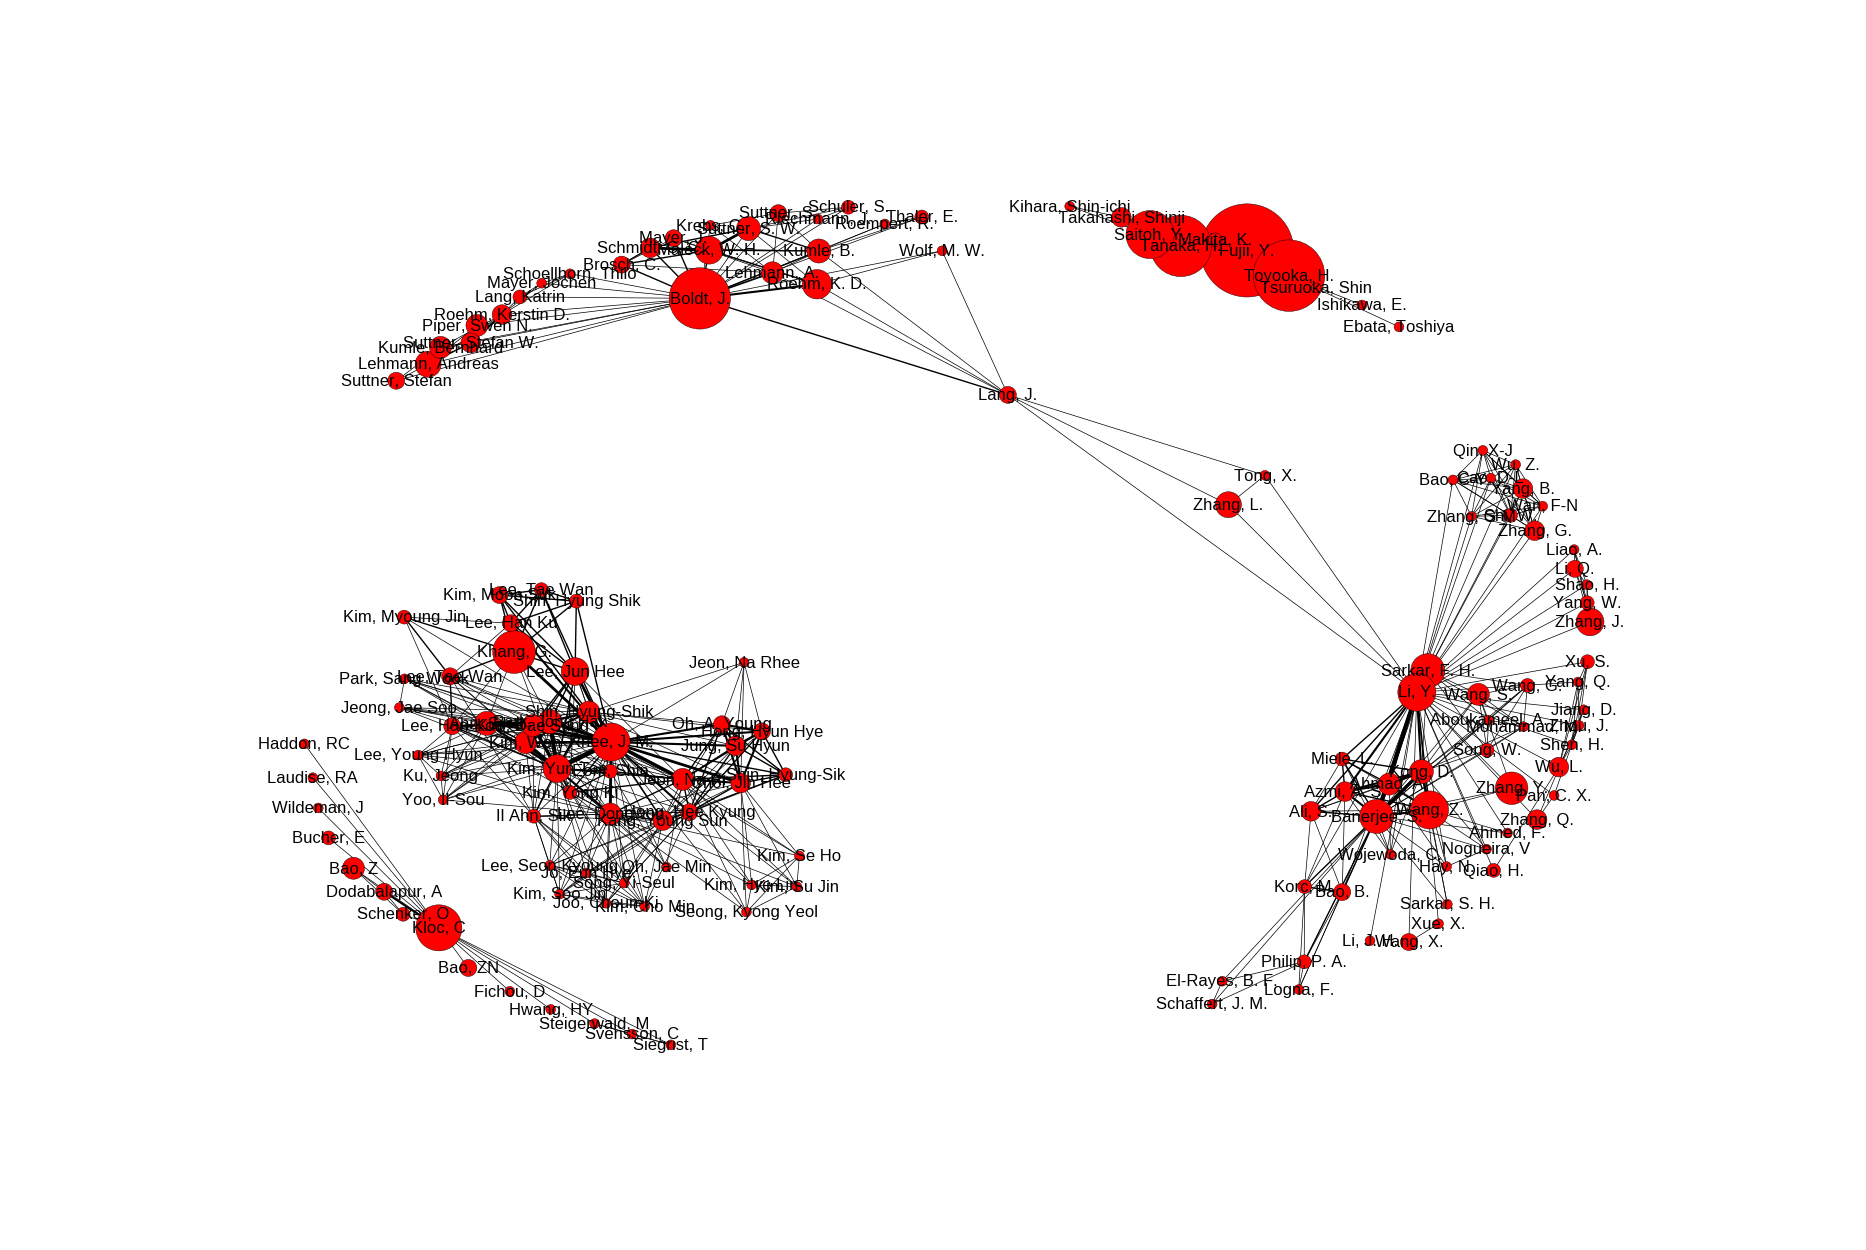

In [73]:
plt.figure(figsize=(18,12))
pos = nx.spring_layout(Top_n_mddl_auth_G)
nx.draw(Top_n_mddl_auth_G, pos, node_size=node_size_ls, width=edge_weight_ls)
nx.draw_networkx_labels(Top_n_mddl_auth_G, pos, node_size=node_size_ls, width=edge_weight_ls);

That is some pretty graph. Let us see if we can make sense of it.
 - Once again, we can identify a number of clusters smaller than 8, 4 precisely.
 - A pattern of "teams" of middle authors appear to arise, with some people having the tendency to participate in each other's retracted papers.
 - A few authors appear to bridge across teams and co-author retracted papers in different areas or across different research groups

## Concluding remarks and future analyses

We explore a nice dataset and drew some interesting insights even at this stage where we primarily confined our investigation to some descriptive statistics and plots. A few more questions can be asked, and answered, by this dataset, such as the distribution of retractions over areas of study, or geography, as well as the evolution over time of the retraction statistics and network. With some additional data, we could compare the statistics we found here with some baseline, as well as analyze the impact of the retractions on the scientific world (via, for instance, citation count).

### Appendix -  Some boilerplate manipulations

#### Building the network

In [38]:
def build_edge_weight_dc(article_ID_ls, adj_author_summary_df, author_label_dc, double=False):
    edge_weight_dc = dict() 
    for art_id in article_ID_ls:
        art_auth_ls = list(adj_author_summary_df['author_name'][adj_author_summary_df['ID']==art_id])
        if 'None' in art_auth_ls:
            art_auth_ls.remove('None')
        #end
        if '{[}Anonymous], ' in art_auth_ls:
            art_auth_ls.remove('{[}Anonymous], ')
        #end
        if len(art_auth_ls)>1:
            for index, a1 in enumerate(art_auth_ls):
                if double:
                    for a2 in art_auth_ls:
                        if author_label_dc[a1]!=author_label_dc[a2]:
                            if (a1, a2) in edge_weight_dc:
                                edge_weight_dc[(a1, a2)] = edge_weight_dc[(a1, a2)] + 1
                            else:
                                edge_weight_dc[(a1, a2)] = 1
                            #end
                        #end
                    #end
                else:
                    for a2 in art_auth_ls[index+1:]:
                        if author_label_dc[a1]<author_label_dc[a2]:
                            if (a1, a2) in edge_weight_dc:
                                edge_weight_dc[(a1, a2)] = edge_weight_dc[(a1, a2)] + 1
                            else:
                                edge_weight_dc[(a1, a2)] = 1
                            #end
                        #end
                    #end
                #end
            #end
        #end
    #end
    return edge_weight_dc
#end

In [39]:
author_ls = list(set(adj_author_summary_df['author_name']))
author_ls.remove('None')
author_ls.remove('{[}Anonymous], ')
article_ID_ls = list(set(adj_author_summary_df['ID']))
author_label_dc = dict(zip(author_ls, range(len(author_ls))))
author_retraction_count_dc = dict(zip(list(auth_df['author_name']), list(auth_df['count'])))
author_retraction_first_dc = dict(zip(list(auth_df['author_name']), list(auth_df['first_author'])))
author_retraction_last_dc = dict(zip(list(auth_df['author_name']), list(auth_df['last_author'])))
author_retraction_middle_dc = dict(zip(list(auth_df['author_name']), list(auth_df['middle_author'])))

#### Engineer the author DataFrame and fix the naming issues

In [28]:
def list_of_el_in_two_lists(list1, list2):
    el_in_2_ls = []
    for el in list1:
        if el in list2:
            el_in_2_ls.append(el)
        #end
    #end
    return el_in_2_ls
#end
def flatten_list(nest_ls):
    flat_list = []
    for el in nest_ls:
        if el is None or el=='Nemo':
            pass
        elif isinstance(el, list):
            flat_list.extend(flatten_list(el))
        else:
            flat_list.append(el)
        #end
    #end
    return flat_list
#end

In [29]:
first_auth_set = list(set(list(summary_df['first_author'])))
last_auth_set = list(set(list(summary_df['last_author'])))
middle_auth_set = list(set(flatten_list(summary_df['middle_authors'].apply(lambda x: ast.literal_eval(x)))))

first_or_last_ls = list_of_el_in_two_lists(first_auth_set, last_auth_set)
fist_or_middle_ls = list_of_el_in_two_lists(first_auth_set, middle_auth_set)
last_or_middle_ls = list_of_el_in_two_lists(last_auth_set, middle_auth_set)
all_positions_ls = list_of_el_in_two_lists(first_or_last_ls, middle_auth_set)
some_multiple_ls = list(set(first_or_last_ls + fist_or_middle_ls + last_or_middle_ls))
all_authors_ls = list(set(first_auth_set + middle_auth_set + last_auth_set))

In [30]:
field_ls = ['ID', 'journal-iso', 'title', 'web-of-science-categories', 'first_author', 'last_author', 'middle_authors']
unpacked_df = summary_df[field_ls]
unpacked_df['middle_authors'] = unpacked_df['middle_authors'].apply(lambda x: ast.literal_eval(x) \
                                                                    if x!='None' else list())
unpacked_summary_df = pd.concat([pd.DataFrame(dict(zip(unpacked_df.columns, 
                                                       unpacked_df.ix[i]))) for i in range(len(unpacked_df))])


/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [31]:
author_summary_dc = {'author_name': [], 'title': [], 'ID': [], 'wos_categories': [], 'first_author': [], 
                     'last_author': [], 'middle_author': []}
for author in all_authors_ls:
    first_author_article_id_ls = list(summary_df['ID'][summary_df['first_author']==author])
    if len(first_author_article_id_ls)>0:
        for article_id in first_author_article_id_ls:
            author_summary_dc['ID'].append(article_id)
            author_summary_dc['author_name'].append(author)
            author_summary_dc['first_author'].append(1)
            author_summary_dc['last_author'].append(0)
            author_summary_dc['middle_author'].append(0)
            author_summary_dc['title'].append(summary_df['title'][summary_df['ID']==article_id])
            author_summary_dc['wos_categories'].append(summary_df['web-of-science-categories'][summary_df['ID']==article_id])
        #end
    #end
    last_author_article_id_ls = list(summary_df['ID'][summary_df['last_author']==author])
    if len(last_author_article_id_ls)>0:
        for article_id in last_author_article_id_ls:
            author_summary_dc['ID'].append(article_id)
            author_summary_dc['author_name'].append(author)
            author_summary_dc['first_author'].append(0)
            author_summary_dc['last_author'].append(1)
            author_summary_dc['middle_author'].append(0)
            author_summary_dc['title'].append(summary_df['title'][summary_df['ID']==article_id])
            author_summary_dc['wos_categories'].append(summary_df['web-of-science-categories']\
                                                       [summary_df['ID']==article_id])
        #end
    #end
    middle_author_article_id_ls = list(unpacked_summary_df['ID'][unpacked_summary_df['middle_authors']==author])
    if len(middle_author_article_id_ls)>0:
        for article_id in middle_author_article_id_ls:
            author_summary_dc['ID'].append(article_id)
            author_summary_dc['author_name'].append(author)
            author_summary_dc['first_author'].append(0)
            author_summary_dc['last_author'].append(0)
            author_summary_dc['middle_author'].append(1)
            author_summary_dc['title'].append(unpacked_summary_df['title'][unpacked_summary_df['ID']==article_id])
            author_summary_dc['wos_categories'].append(unpacked_summary_df['web-of-science-categories']\
                                                       [unpacked_summary_df['ID']==article_id])
        #end
    #end
#end
            
author_summary_df = pd.DataFrame(data=author_summary_dc)

In [32]:
author_summary_df.head(3)

,ID,author_name,first_author,last_author,middle_author,title,wos_categories
0,ISI:000315707300037,"Bose, Julie S.",1,0,0,1989 A Dihydrobenzofuran Lignan Induces Cel...,"1989 Chemistry, Medicinal Name: web-of-scie..."
1,ISI:000239914800070,"Rockley, M. G.",0,0,1,0 Theoretical investigation of the dissocia...,"0 Chemistry, Physical; Physics, Atomic, Mol..."
2,ISI:000180655500059,"Onoda, N",0,0,1,0 A novel bone marrow stroma-derived growth...,0 Immunology 1 Immunology 2 Immunolog...


In [33]:
same_author_dc = {'Fujii, Yoshitaka': 'Fujii, Y.',
                  'Toyooka, Hidenori': 'Toyooka, H.',
                  'Tanaka, Hiroyoshi': 'Tanaka, H.',
                  'Saitoh, Yuhji': 'Saitoh, Y.',
                  'Stapel, Diederik A.': 'Stapel, D. A.',
                  'Stapel, D.': 'Stapel, D. A.',
                  'Mori, Naoki': 'Mori, N.',
                  'Kato, Shigeaki': 'Kato, S.',
                  'Aggarwal, Bharat B.': 'Aggarwal, B. B.',
                  'Boldt, Joachim': 'Boldt, J.',
                  'Hunton, James E.': 'Hunton, J. E.',
                  'Tomita, Mariko': 'Tomita, M.',
                  'Potti, Anil': 'Potti, A.',
                  'Khang, Gilson': 'Khang, G.',
                  'Zaman, Khalid': 'Zaman, K.',
                  'Rhee, John M.': 'Rhee, J. M.',
                   'Kitagawa, Hirochika': 'Kitagawa, H.',
                  'Lichtenthaler, Ulrich': 'Lichtenthaler, U.',
                  'Pease, Larry R.': 'Pease, L. R.',
                  }

adj_author_summary_df = author_summary_df.copy(deep=True)
for old_name, new_name in zip(same_author_dc.keys(), same_author_dc.values()):
    adj_author_summary_df['author_name'][adj_author_summary_df['author_name']==old_name] = new_name
#end

/usr/local/lib/python2.7/dist-packages/ipykernel/__main__.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
